In [1]:
#import all relevant libraries
import cleaning as cl
import visualisation as vs
import models as mod
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Machine Leaning Project - Kickstarter
In this project, we analyze the kickstarter dataset and build several machine learning models. Our goal is to help an investor find a project to invest in. The investor is only interested in projects that are going to be successful.

## Import and data cleaning
First, we need to import the data. Then we remove duplicate entries.

In [2]:
#import data and safe it so the df_kick dataframe
df_kick = cl.read_data("data/")
#remove all duplicate entries
df_kick = cl.drop_duplicate(df_kick,"id")


Total number of entries: 209222
Number of unique entries: 182264
Number of rows that will be deleted: 26958


### Further data cleaning
We will drop the missing "blurb" entries, since this is important information we want to have. For now, we'll ignore the missing "location" values as this column might be redundant anyway.

Our analysis and research showed, that the "goal" is in the foreign currency. Since we want to compare all projects in USD, we transform "goal" to USD using the given "static_usd_rate". After that, we remove the now redundant columns

Possible states are live, successful, canceled, failed and suspended.
We drop live states, since they're not finished.
We also drop suspended states, as they are only 600 and we don't know exactly why they have been suspended.

We add canceled to failed, since for our use case the outcome is identical.

Since state is the feature we want to predict, we transform it into a 1/0 categorical variable.

All data cleaning is combined in the following function.

In [3]:
df_kick.reset_index()

,index,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,...,babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",28645.000000,international
1,1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,...,the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1950.000000,domestic
2,2,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,...,record-electras-debut-album-pop-rock-classical,https://www.kickstarter.com/discover/categorie...,True,False,successful,1371013395,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",22404.000000,international
3,3,3,The Mist of Tribunal is a turn-based card game...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,...,the-mist-of-tribunal-a-card-game,https://www.kickstarter.com/discover/categorie...,False,False,failed,1489425776,1.216066,"{""web"":{""project"":""https://www.kickstarter.com...",165.384934,domestic
4,4,3,"Livng with a brain impairment, what its like t...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,...,help-change-the-face-of-brain-impairment,https://www.kickstarter.com/discover/categorie...,True,False,successful,1357763527,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2820.000000,domestic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182259,209216,108,*PRE-SALES* for Our first Full-Length Album- c...,"{""id"":38,""name"":""Electronic Music"",""slug"":""mus...",4078,US,1405625585,"{""id"":356376150,""name"":""Pepper Proud"",""is_regi...",USD,$,...,it-springs-to-lifepellucidity-yaimas-first-album,https://www.kickstarter.com/discover/categorie...,True,False,successful,1412207040,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",4078.220000,domestic
182260,209218,72,"Soul, hip-hop and sexy falsettos with an opera...","{""id"":38,""name"":""Electronic Music"",""slug"":""mus...",5710,NL,1493041572,"{""id"":1412154830,""name"":""Lester Arias is ARIA ...",EUR,€,...,aria-lester-debut-ep,https://www.kickstarter.com/discover/categorie...,True,False,successful,1497909600,1.093300,"{""web"":{""project"":""https://www.kickstarter.com...",5575.830204,domestic
182261,209219,62,What started as a homemade gift has turned int...,"{""id"":52,""name"":""Hardware"",""slug"":""technology/...",2681,US,1341343795,"{""id"":891767476,""name"":""Doug Stienstra"",""is_re...",USD,$,...,flashpals-cuddly-usb-drives-save-more-than-you...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1347854341,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2681.000000,international
182262,209220,76,Seattle Transmedia & Independent Film Festival...,"{""id"":295,""name"":""Festivals"",""slug"":""film & vi...",5692,US,1425256957,"{""id"":307076473,""name"":""Timothy Vernor"",""is_re...",USD,$,...,transmedia-gallery-space-stiff-2015,https://www.kickstarter.com/discover/categorie...,True,False,successful,1429536379,1.000000,"{""web"":{""project"":""https://www.kick

In [4]:
df_kick = cl.clean_data(df_kick)

## Descriptive Statistics
Before building different models, we have a closer look at out data. We look at the distribution of our target feature, the state variable, to see how balanced out dataset is. In addition we look at a correlation matrix, some histograms and pairplots.

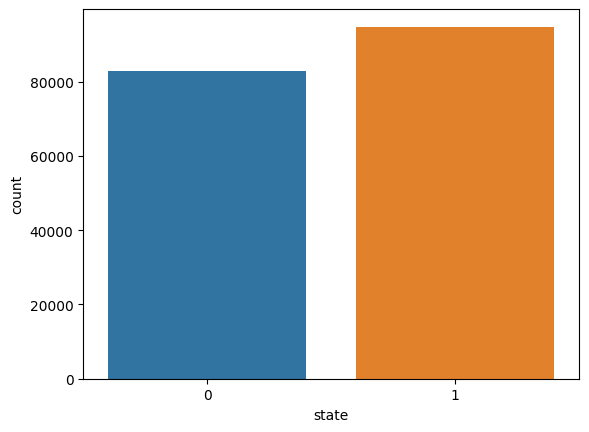

In [6]:
#check how balanced our dataset is
vs.countplot(df_kick, "state")

Out dataset is only slightly unbalaced with approx. 53% of the data being in state 1

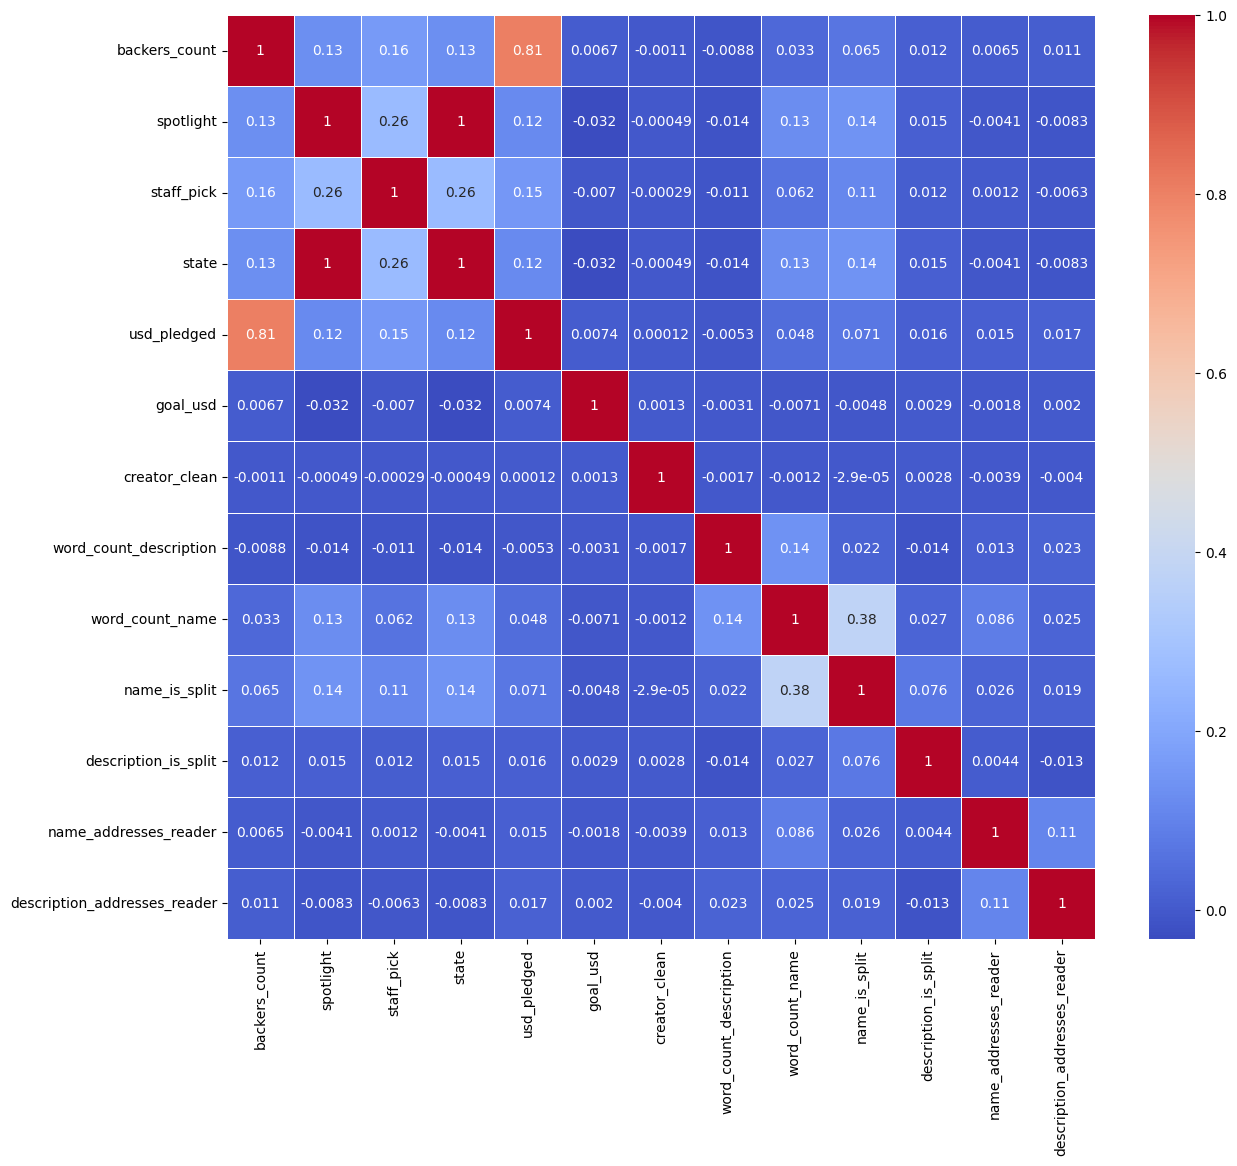

In [7]:
vs.corr_map(df_kick.drop("disable_communication",axis=1))

The features splotlight and state are 100% correlated. Hence, we drop spotlight.

In addition, usd_pledged and backers_count are highly correlated as well. This makes sense. However, we don't want to use these two features for our models since they are not known in advance.

In [8]:
df_kick = df_kick.drop("spotlight", axis=1) 

## Baseline Model
Our baseline model is to simply predict the positive outcome (state=successful) by the value of the goal in USD. As the threshold we choose the mean of all goal_usd values which is 5000$.

Baseline :
Accuracy: 0.5955854613024015
Recall: 0.5729222718112662
Precision: 0.6340241695370424


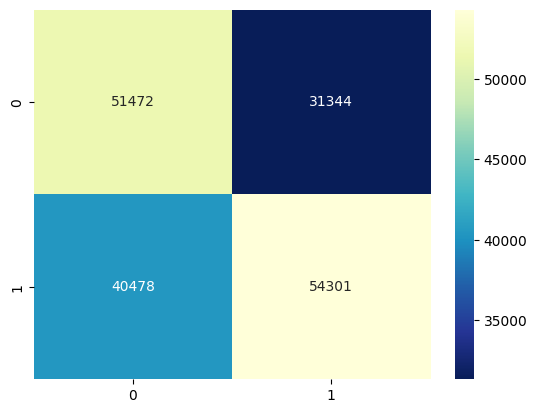

In [9]:
y_pred_baseline = mod.baseline(df_kick,"goal_usd",5000)
mod.eval_metrics(df_kick.state, y_pred_baseline, "Baseline")

So our very basic model is already better than randomly guessing. We chose precision as our main evaluation metric since our stakeholder in interested in accurate information about the probability of success. Our baseline model has a precision of 63%.

Now we try a model that is a little more complex, but still very simple. The model consists of a logistic regression with only one feature.

Logistic Regression :
Accuracy: 0.8271347729384273
Recall: 0.7546642774322757
Precision: 0.9060364464692483


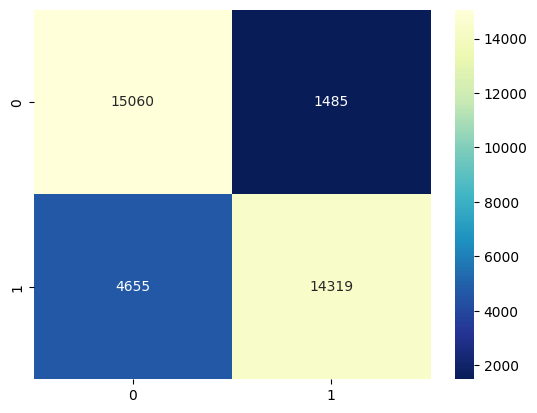

In [10]:
y = df_kick.state
X_simple = df_kick[["backers_count"]]
X_train_simple, X_test_simple, y_train, y_test = train_test_split(X_simple, y, test_size = 0.2, random_state = 0)

y_pred_simple = mod.simple_model(X_train_simple, y_train, X_test_simple)
mod.eval_metrics(y_test, y_pred_simple, "Logistic Regression")


The simple model based on backers_count has a precision of 91%. So backers_count is a very good predictor for the positive or negative outcome of the project. However, backers_count is not know in advance, so we do not use this feature for our models.

## Pipelines

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [12]:
df_kick.columns

Index(['backers_count', 'blurb', 'category', 'country', 'created_at',
       'creator', 'disable_communication', 'name', 'slug', 'staff_pick',
       'state', 'usd_pledged', 'goal_usd', 'category_clean', 'creator_clean',
       'word_count_description', 'word_count_name', 'name_is_split',
       'description_is_split', 'name_addresses_reader',
       'description_addresses_reader'],
      dtype='object')

In [13]:
df_kick.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177595 entries, 0 to 177602
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   backers_count                 177595 non-null  int64         
 1   blurb                         177595 non-null  object        
 2   category                      177595 non-null  object        
 3   country                       177595 non-null  object        
 4   created_at                    177595 non-null  datetime64[ns]
 5   creator                       177595 non-null  object        
 6   disable_communication         177595 non-null  bool          
 7   name                          177595 non-null  object        
 8   slug                          177595 non-null  object        
 9   staff_pick                    177595 non-null  bool          
 10  state                         177595 non-null  int64         
 11  usd_pledged  

In [14]:
num_features = ["goal_usd"]
cat_features = ["category_clean", "country","staff_pick","word_count_description","word_count_name","name_is_split","description_is_split","name_addresses_reader","description_addresses_reader"] #creator_clean

In [15]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])
# Complete pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [16]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])
# Building a full pipeline with our preprocessor and a DecisionTree Classifier
pipe_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier())
])
# Building a full pipeline with our preprocessor and a RandomForest Classifier
pipe_random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier())
])

In [17]:
#choose our features & build train- and test-set
temp  = cat_features + num_features
X = df_kick[temp]
y = df_kick["state"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [29]:
param_logreg = {'logreg__penalty':('none','l1','l2'),
                'logreg__C': np.logspace(-2,5,10),
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

rs_logreg = RandomizedSearchCV(pipe_logreg, param_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state=17)

In [28]:
np.logspace(0,7,10)

array([1.00000000e+00, 5.99484250e+00, 3.59381366e+01, 2.15443469e+02,
       1.29154967e+03, 7.74263683e+03, 4.64158883e+04, 2.78255940e+05,
       1.66810054e+06, 1.00000000e+07])

In [32]:
param_tree = {'tree__criterion': ['gini', 'entropy'],
                'tree__splitter': ['best', 'random'],
                'tree__min_samples_split': range(1,300)
               }

rs_tree = RandomizedSearchCV(pipe_tree, param_tree, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state=17)

In [41]:
# Defining parameter space for randomized search. 
param_random_forest = {'random_forest__n_estimators' : range(1,100),
            'random_forest__criterion': ['gini', 'entropy'],
            'random_forest__min_samples_leaf': range(1,100)
               }

rs_random_forest = RandomizedSearchCV(pipe_random_forest, param_random_forest, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state = 7)

In [30]:
#rs_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END logreg__C=0.05994842503189409, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.688 total time=   1.8s
[CV 1/5] END logreg__C=0.05994842503189409, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.688 total time=   2.1s
[CV 2/5] END logreg__C=0.05994842503189409, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.688 total time=   1.9s
[CV 1/5] END logreg__C=0.05994842503189409, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 2/5] END logreg__C=0.05994842503189409, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 3/5] END logreg__C=0.05994842503189409, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.1s
[CV 4/5] END logreg__C=0.05994842503189409, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.1s
[CV 5/5] END logreg__C=0.05994842503189409, logreg__penalty=none, logreg__solver=liblinear;, scor

/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END logreg__C=2.1544346900318843, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   4.4s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END logreg__C=2.1544346900318843, logreg__penalty=none, logreg__solver=lbfgs;, score=0.696 total time=   5.8s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=2.1544346900318843, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=   6.5s
[CV 1/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.1s
[CV 2/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 3/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 4/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.1s
[CV 5/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.1s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END logreg__C=2.1544346900318843, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   3.6s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END logreg__C=2.1544346900318843, logreg__penalty=none, logreg__solver=lbfgs;, score=0.691 total time=   6.1s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   4.7s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=lbfgs;, score=0.696 total time=   6.1s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   3.3s
[CV 1/5] END logreg__C=2.1544346900318843, logreg__penalty=l2, logreg__solver=liblinear;, score=0.696 total time=   1.5s
[CV 3/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=   6.6s
[CV 2/5] END logreg__C=2.1544346900318843, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   1.4s
[CV 5/5] END logreg__C=100000.0, logreg__penalty=none, logreg__solver=lbfgs;, score=0.691 total time=   6.0s
[CV 3/5] END logreg__C=2.1544346900318843, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   1.5s
[CV 4/5] END logreg__C=2.1544346900318843, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   1.5s
[CV 5/5] END logreg__C=2.1544346900318843, logreg__penalty=l2, logreg__solver=liblinear;, score=0.691 total time=   1.3s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

[CV 2/5] END logreg__C=464.1588833612782, logreg__penalty=l2, logreg__solver=sag;, score=0.694 total time=  55.7s
[CV 5/5] END logreg__C=464.1588833612782, logreg__penalty=l2, logreg__solver=sag;, score=0.690 total time=  55.8s
[CV 3/5] END logreg__C=464.1588833612782, logreg__penalty=l2, logreg__solver=sag;, score=0.692 total time=  55.8s
[CV 4/5] END logreg__C=464.1588833612782, logreg__penalty=l2, logreg__solver=sag;, score=0.693 total time=  55.7s
[CV 1/5] END logreg__C=464.1588833612782, logreg__penalty=l2, logreg__solver=sag;, score=0.695 total time=  55.9s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['goal_usd']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['category_clean',
                                                                               

In [31]:
# Best score
#print('Best score:', round(rs_logreg.best_score_, 3))

# Best parameters
#print('Best parameters:', rs_logreg.best_params_)

Best score: 0.694
Best parameters: {'logreg__solver': 'lbfgs', 'logreg__penalty': 'none', 'logreg__C': 2.1544346900318843}


Results:
|Best score|solver|penalty|C|
|---|---|---|---|
|0.694|lbfgs|none|2.15|

In [36]:
#rs_tree.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END tree__criterion=gini, tree__min_samples_split=72, tree__splitter=random;, score=0.696 total time=   4.6s
[CV 3/5] END tree__criterion=gini, tree__min_samples_split=72, tree__splitter=random;, score=0.694 total time=   4.5s
[CV 2/5] END tree__criterion=gini, tree__min_samples_split=72, tree__splitter=random;, score=0.701 total time=   4.6s
[CV 1/5] END tree__criterion=entropy, tree__min_samples_split=13, tree__splitter=random;, score=0.680 total time=   6.6s
[CV 3/5] END tree__criterion=entropy, tree__min_samples_split=13, tree__splitter=random;, score=0.678 total time=   6.8s
[CV 5/5] END tree__criterion=entropy, tree__min_samples_split=13, tree__splitter=random;, score=0.675 total time=   6.8s
[CV 2/5] END tree__criterion=entropy, tree__min_samples_split=13, tree__splitter=random;, score=0.682 total time=   7.1s
[CV 4/5] END tree__criterion=entropy, tree__min_samples_split=13, tree__splitter=random;, score=0.679

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['goal_usd']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['category_clean',
                                                                               

In [37]:
# Best score
#print('Best score:', round(rs_tree.best_score_, 3))

# Best parameters
#print('Best parameters:', rs_tree.best_params_)

Best score: 0.702
Best parameters: {'tree__splitter': 'best', 'tree__min_samples_split': 235, 'tree__criterion': 'gini'}


Results:
|Best score|splitter|min samples split|criterion|
|---|---|---|---|
|0.703|random|222|entropy|
|0.661|best|235|gini|

In [42]:
#rs_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=72, random_forest__n_estimators=92;, score=0.705 total time=  13.3s
[CV 1/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=72, random_forest__n_estimators=92;, score=0.711 total time=  13.5s
[CV 3/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=72, random_forest__n_estimators=92;, score=0.706 total time=  13.4s
[CV 5/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=72, random_forest__n_estimators=92;, score=0.703 total time=  13.5s
[CV 4/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=72, random_forest__n_estimators=92;, score=0.708 total time=  13.7s
[CV 2/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=10, random_forest__n_estimators=51;, score=0.712 total time=  20.2s
[CV 3/5] END random_forest__criterion=entropy, random_for

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['goal_usd']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['category_clean',
                                                                               

In [43]:
# Best score
#print('Best score:', round(rs_random_forest.best_score_, 3))

# Best parameters
#print('Best parameters:', rs_random_forest.best_params_)

Best score: 0.713
Best parameters: {'random_forest__n_estimators': 86, 'random_forest__min_samples_leaf': 14, 'random_forest__criterion': 'gini'}


Results:
|Best score|n_estimators|min_samples_leaf|criterion|
|---|---|---|---|
|0.713|83|13|entropy|
|0.661|86|14|gini|

In [44]:
# Defining parameter space for grid search.
param_logreg = {'logreg__penalty':['none','l2'],
                'logreg__C': [1,1.5,2,2.5,3],
                'logreg__solver': ['liblinear', 'lbfgs']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)


param_tree = {'tree__criterion': ['entropy','gini'],
                'tree__splitter': ['random','best'],
                'tree__min_samples_split': range(220,240)
               }

grid_tree = GridSearchCV(pipe_tree, param_grid=param_tree, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)


param_random_forest = {'random_forest__n_estimators' : [80,85,90],
            'random_forest__criterion': ['gini','entropy'],
            'random_forest__min_samples_leaf': [13,14,15]
               }

grid_random_forest = GridSearchCV(pipe_random_forest, param_grid=param_random_forest, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

In [45]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 2/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 3/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 4/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 5/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.2s
[CV 2/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.4s
[CV 1/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=liblinear;, score=0.695 total time=   2.5s
[CV 3/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   2.3s
[CV 4/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.4s
[C

/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   3.2s
[CV 3/5] END logreg__C=1, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=   8.6s
[CV 3/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   3.2s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.690 total time=   3.1s
[CV 2/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.2s
[CV 3/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.692 total time=   2.4s
[CV 1/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.695 total time=   2.9s
[CV 4/5] END logreg__C=1.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   4.9s
[CV 4/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.6s
[CV 2/5] END logreg__C=1.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   5.7s
[CV 5/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.691 total time=   2.5s
[CV 1/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.695 total time=   3.3s
[CV 1/5] END logreg__C=2, logreg__penalty=none, logreg__solv

/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=1.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=   8.7s
[CV 4/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   3.0s
[CV 2/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   3.6s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.691 total time=   3.5s
[CV 3/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   3.9s
[CV 1/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.696 total time=   2.6s
[CV 2/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.3s
[CV 3/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   2.4s
[CV 2/5] END logreg__C=2, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   5.4s
[CV 4/5] END logreg__C=2, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   4.7s
[CV 4/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.5s
[CV 5/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.691 total time=   2.4s
[CV 1/5] END logreg__C=2, logreg__penalty=none, logreg__solver=lbfgs;, s

/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1

[CV 3/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   3.9s
[CV 4/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   3.6s
[CV 5/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.691 total time=   3.5s
[CV 1/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.696 total time=   2.6s
[CV 2/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.5s
[CV 3/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   2.6s
[CV 4/5] END logreg__C=2.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   5.0s
[CV 2/5] END logreg__C=2.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   6.2s
[CV 4/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   2.8s
[CV 5/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=libli

/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=2.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=   9.1s
[CV 2/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   4.2s


/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lisa/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   3.6s
[CV 5/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.691 total time=   3.4s
[CV 4/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   4.2s
[CV 2/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.4s
[CV 1/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.696 total time=   2.6s
[CV 3/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.692 total time=   2.6s
[CV 4/5] END logreg__C=3, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   4.6s
[CV 2/5] END logreg__C=3, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   5.7s
[CV 4/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   2.7s
[CV 5/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['goal_usd']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['category_clean',
                                                                          'country',
                                                      

In [46]:
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.702 total time=   2.7s
[CV 2/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.703 total time=   2.9s
[CV 4/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.707 total time=   3.0s
[CV 5/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.708 total time=   2.9s
[CV 3/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.700 total time=   3.1s
[CV 1/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=best;, score=0.702 total time=   3.7s
[CV 2/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=best;, score=0.702 total time=   3.7s
[CV 3/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=best;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['goal_usd']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['category_clean',
                                                                          'country',
                                                      

In [47]:
grid_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.717 total time=  24.2s
[CV 3/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.710 total time=  24.9s
[CV 2/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.712 total time=  25.0s
[CV 4/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.713 total time=  24.9s
[CV 5/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.709 total time=  24.9s
[CV 3/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=85;, score=0.707 total time=  25.3s
[CV 1/5] END random_forest__criterion=gini, random_forest__min_samples_leaf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['goal_usd']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['category_clean',
                                                                          'country',
                                                      

In [48]:
# Show best parameters
print('Best score logreg:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters logreg:\n{}".format(grid_logreg.best_params_))
print('Best score tree:\n{:.2f}'.format(grid_tree.best_score_))
print("Best parameters tree:\n{}".format(grid_tree.best_params_))
print('Best score random forest:\n{:.2f}'.format(grid_random_forest.best_score_))
print("Best parameters random forest:\n{}".format(grid_random_forest.best_params_))

Best score logreg:
0.69
Best parameters logreg:
{'logreg__C': 1, 'logreg__penalty': 'none', 'logreg__solver': 'lbfgs'}
Best score tree:
0.70
Best parameters tree:
{'tree__criterion': 'gini', 'tree__min_samples_split': 239, 'tree__splitter': 'random'}
Best score random forest:
0.71
Best parameters random forest:
{'random_forest__criterion': 'gini', 'random_forest__min_samples_leaf': 14, 'random_forest__n_estimators': 85}


In [49]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model_logreg = grid_logreg.best_estimator_
best_model_tree = grid_tree.best_estimator_
best_model_random_forest = grid_random_forest.best_estimator_


In [50]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_train_predicted_logreg = best_model_logreg.predict(X_train)
y_train_predicted_tree = best_model_tree.predict(X_train)
y_train_predicted_random_forest = best_model_random_forest.predict(X_train)
y_test_predicted_logreg = best_model_logreg.predict(X_test)
y_test_predicted_tree = best_model_tree.predict(X_test)
y_test_predicted_random_forest = best_model_random_forest.predict(X_test)


In [51]:
mod.eval_metrics(y_train,y_train_predicted_logreg, "logistic regression - train", False)
mod.eval_metrics(y_test,y_test_predicted_logreg, "logistic regression - test", False)
mod.eval_metrics(y_train,y_train_predicted_tree, "decision tree - train", False)
mod.eval_metrics(y_test,y_test_predicted_tree, "decision tree - test", False)
mod.eval_metrics(y_train,y_train_predicted_random_forest, "random forest - train", False)
mod.eval_metrics(y_test,y_test_predicted_random_forest, "random forest - test", False)

logistic regression - train :
Accuracy: 0.6994425518736451
Recall: 0.7800408944001055
Precision: 0.6943599619535222
logistic regression - test :
Accuracy: 0.6973450829133703
Recall: 0.7801728681353431
Precision: 0.6923112898699841
decision tree - train :
Accuracy: 0.7225358258959993
Recall: 0.768339819273135
Precision: 0.7271047638070508
decision tree - test :
Accuracy: 0.6975421605337988
Recall: 0.7472330557605144
Precision: 0.7044968944099379
random forest - train :
Accuracy: 0.7281032686731045
Recall: 0.794169250049469
Precision: 0.7233296086700549
random forest - test :
Accuracy: 0.7150539148061601
Recall: 0.785759460314114
Precision: 0.7111376103028858


In [52]:
#Max Voting
from sklearn.ensemble import VotingClassifier

model1 = best_model_logreg #LogisticRegression(random_state = 24)
model2 = best_model_tree # DecisionTreeClassifier(random_state = 24)
model3 = best_model_random_forest #RandomForestClassifier(random_state = 24)

model = VotingClassifier(estimators = [('lr', model1), ('dt', model2), ('rf', model3)], voting = 'hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.7130549846560995

In [53]:
y_test_predicted_voting = model.predict(X_test)
y_train_predicted_voting = model.predict(X_train)

In [54]:
mod.eval_metrics(y_train,y_train_predicted_voting, "voting - train", False)
mod.eval_metrics(y_test,y_test_predicted_voting, "voting - test", False)

voting - train :
Accuracy: 0.7256820293364115
Recall: 0.7933777455312974
Precision: 0.7206691191449079
voting - test :
Accuracy: 0.7130549846560995
Recall: 0.7849162011173184
Precision: 0.7090554180156161
